# Project: Measuring impact of green infrastructure projects on stormwater capture in urban environments 

This project has the following goals:
1. Measure the role and impact of green infrastructure (GI) projects on stormwater capture and discharge in an urban area

2. Measure the change in urban greenspace over time and analyze how stormwater capture/dischage rates correlate with these changes


## What is a Green Infrastucture Project?  
Green infrastructure projects are geo-engineered features that help redirect and recapture stormwater runoff from urban hardscapes 

GI projects can be site-scale projects such as water retention ponds and bioswales, or urban-scale projects such as greenways and infiltration catchment areas to help: 
- More effectively recapture groundwater resources
- Help flatten spikes in peak flow volumes after heavy precipitation
- Reduce pollutant discharge into local water systems 

## How will these be measured? 

To view the impact of green infrastucture projects on stormwater capture, we will use measure the Normalized Difference Moisture Index (NDMI) to measure the soil moisture content of both project areas and the surrounding region. 

Ideally, these project areas will show greater effectivness in capturing and retaining stormwater runoff via more saturated soils. 

## How exactly does NDMI correlate with soil water levels? 

This table below shows how the NDMI measurement relates to different levels of soil saturation and/or water stress for a given area:

| NDMI | Interpretation |
|   :---   |   :---  |
|-1 – -0.8 |Bare soil |
|-0.8 – -0.6 | Almost absent canopy cover |
|-0.6 – -0.4 | Very low canopy cover |
|-0.4 – -0.2 |Low canopy cover, dry or very low canopy cover, wet |
|-0.2 – 0 |Mid-low canopy cover, high water stress or low canopy cover, low water stress |
|0 – 0.2 |Average canopy cover, high water stress or mid-low canopy cover, low water stress |
|0.2 – 0.4 |Mid-high canopy cover, high water stress or average canopy cover, low water stress |
|0.4 – 0.6 |High canopy cover, no water stress |
|0.6 – 0.8 |Very high canopy cover, no water stress |
|0.8 – 1 |Total canopy cover, no water stress/waterlogging |

## Prep Step #1: Import Python Packages

In [1]:
# Import Packages

import os
from glob import glob
from datetime import datetime

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger

from itertools import groupby
    
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping
import numpy.ma as ma
from rasterio.plot import plotting_extent
import rasterstats as rs
from shapely.geometry import box

%matplotlib inline

## Prep Step #2: Set up required data paths for analysis 

In [2]:
# set up paths to data

# Download data and set working directory
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

# LA spreading grounds shapefiles
shape_spread_path = os.path.join("capstone",
                                 "la-spreading-grounds",
                                 "Spreading_Grounds_Feature_Layer.shp")                                 
shape_spread_data = gpd.read_file(shape_spread_path)

#LA catchment areas shapefiles
shape_catchment_path = os.path.join("capstone",
                                    "la-catchment-areas",
                                    "Los_Angeles_County_Catchment_Areas.shp")                                 
shape_catchment_data = gpd.read_file(shape_catchment_path)

#LA area region crop 
la_crop_path = os.path.join("capstone",
                       "Sentinel-2-Shapefile-Index",
                       "sentinel_2_index_shapefile.shp")

la_crop_data = gpd.read_file(la_crop_path).loc[
                                            gpd.read_file(la_crop_path)["Name"]=="11SLT"]

#City boundaries shapefiles

city_boundaries_path = os.path.join("capstone",
                                    "la-city-boundaries",
                                    "City_Boundaries.shp")   

city_boundaries_data = gpd.read_file(city_boundaries_path)

#LA streams and rivers shapefiles 
la_streams_rivers_path = os.path.join("capstone",
                                     "la-streams-rivers",
                                     "geo_export_339f28ec-e123-431b-a506-4d994dfd8153.shp")
la_streams_rivers_data = gpd.read_file(la_streams_rivers_path)


#Sentinel-2 data paths
sent_jan_2022_path = os.path.join("capstone", 
                                  "sent-jan-2022")
sent_jul_2021_path = os.path.join("capstone", 
                                  "sent-jul-2021")

sent_all_2021_path = os.path.join("capstone", 
                                  "sent-all-2021")

#Select path that will be used primarily for analysis
sent_path = os.path.join(sent_all_2021_path)

#Paths to access NIR (Band 8) and SWIR (Band 11) 
band_8_paths = glob(os.path.join(sent_path,"*B08*.tif")) 
band_11_paths = glob(os.path.join(sent_path,"*B11*.tif"))
ndmi_band_paths = band_8_paths + band_11_paths

## Prep Step #3: Create functions needed to open clean and masked bands

In [3]:
def open_clean_bands(band_path,
                     crop_bound,
                     valid_range,
                    pixel_qa_path):
    
    """
    Open, clean, and crop a file into an xarray DataArray.

    Parameters
    -----------
    band_path:string
        A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
         A tuple of min and max range of values for the data. Default = None

    Returns
    -----------

    band : xarray DataArray
        End result for a cropped xarray dataarray
    """

    crop_bound_box = [box(*crop_bound.total_bounds)]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True).rio.clip(
                                                        crop_bound_box,
                                                        crs=crop_bound.crs,
                                                        all_touched=True,
                                                        from_disk=True).squeeze()
    
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

        # open and mask cloud layer
        cl_mask = (rxr.open_rasterio(pixel_qa_path, masked=True)
                        .rio.clip(crop_bound.geometry, from_disk=True)
                        .squeeze())

        # apply cloud mask
        band = band.where(cl_mask.isin(goodQuality)).squeeze()
        
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")


    return band

## Prep Step #4: Create necessary crop bounds using site, city, and project area shapefiles  ##

- Site area = Los Angeles County (MGRS: 11SLT) 
- Project area = Eaton Spreading Grounds
- Related city area for Eaton Spreading Grounds = Pasadena, CA

In [4]:
# test bands for a single site 

#band 8
test_tif_8 = os.path.join("capstone",
                          "sent-all-2021",
                        "HLS.S30.T11SLT.2021003T183751.v2.0.B08.tif")

#band 11
test_tif_11 = os.path.join("capstone", 
                           "sent-all-2021",
                        "HLS.S30.T11SLT.2021003T183751.v2.0.B11.tif")

#create rasters for bands 8 and 11
test_rxr_8 = rxr.open_rasterio(test_tif_8,masked=True).squeeze()


test_rxr_11 = rxr.open_rasterio(test_tif_11,masked=True).squeeze()


#reproject shape files to crs 
la_reproj_crop = la_crop_data.to_crs(test_rxr_11.rio.crs)


#spreading ground reprojections for Eaton Spreading Grounds

spreading_shape_reproj = shape_spread_data.to_crs(test_rxr_11.rio.crs)
eaton_shape = spreading_shape_reproj.loc[
                                        spreading_shape_reproj['NAME'] == "EATON S.G."]

#Reprojections for other potential shapefiles 

la_streams_rivers_reproj = la_streams_rivers_data.to_crs(test_rxr_11.rio.crs)

city_boundaries_reproj = city_boundaries_data.to_crs(test_rxr_11.rio.crs)
pasadena_shape = city_boundaries_reproj.loc[
                                        city_boundaries_reproj['CITY_NAME'] == "Pasadena"]

#create plot extents for site (LA) and project area (Eaton SG)

la_plot_extent = plotting_extent(test_rxr_11, 
                                   test_rxr_11.rio.transform())

eaton_shape

,OBJECTID,ID,NAME,OWNER_OPER,BASIN_TYPE,NO__OF_BAS,SEASON_FIR,GROSS_AREA,WETTED_ARE,CHANNEL,INTAKES,STORAGE,PERCOLATIO,CONTROLLED,UNCONTROLL,EQNUM,MXCREATION,SHAPEAREA,SHAPELEN,geometry
34,35,W,EATON S.G.,LOS ANGELES COUNTY - DPW,DEEP & SHALLOW,14,1947-48,28 ACRES,25.0 ACRES,6600 CFS,200 CFS,525 AF,14 CFS,EATON WASH DAM,IMPORTED WATER,None,1,5.282895e+06,25754.052128,"MULTIPOLYGON (((399200.586 3781846.894, 399202..."


## Prep Step #5: Create Cloud Mask Layers 

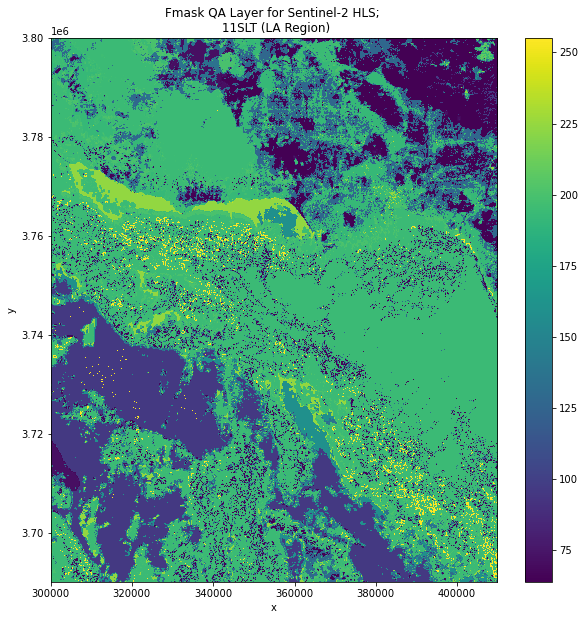

In [5]:
# Create path for the pixel_qa_layer for subdirectory scene
scene_pixel_qa_path = os.path.join(sent_path,
                                  "HLS.S30.T11SLT.2021003T183751.v2.0.Fmask.tif")

sent_qa = rxr.open_rasterio(scene_pixel_qa_path).squeeze()

sent_qa
fig, ax = plt.subplots(figsize=(10,10))
sent_qa.plot.imshow(ax=ax)
plt.title("Fmask QA Layer for Sentinel-2 HLS; \n 11SLT (LA Region)")
plt.show()


## Follow Sentinel-2 HLS documentation to create masking value references ## 

Git: https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/HLS_Tutorial.ipynb#processhls

In [6]:
# bitword dictionaries 

bitword_order = (1, 1, 1, 1, 1, 1, 2)  # set the number of bits per bitword
num_bitwords = len(bitword_order)      # Define the number of bitwords based on your input above
total_bits = sum(bitword_order)        # Should be 8, 16, or 32 depending on datatype

In [7]:
# Loop to create cloud mask lookup from Git documentation 

qVals = list(np.unique(sent_qa))  # Create a list of unique values that need to be converted to binary and decoded
all_bits = list()
goodQuality = []
for v in qVals:
    all_bits = []
    bits = total_bits
    i = 0
    
    # Convert to binary based on the values and # of bits defined above:
    bit_val = format(v, 'b').zfill(bits)
    all_bits.append(str(v) + ' = ' + str(bit_val))

    # Go through & split out the values for each bit word based on input above:
    for b in bitword_order:
        prev_bit = bits
        bits = bits - b
        i = i + 1
        if i == 1:
            bitword = bit_val[bits:]
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword)) 
        elif i == num_bitwords:
            bitword = bit_val[:prev_bit]
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
        else:
            bitword = bit_val[bits:prev_bit]
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
            
    # 2, 4, 5, 6 are the bits used. All 4 should = 0 if no clouds, cloud shadows were present, and pixel is not snow/ice/water
    if int(all_bits[2].split(': ')[-1]) + int(all_bits[4].split(': ')[-1]) + \
    int(all_bits[5].split(': ')[-1]) + int(all_bits[6].split(': ')[-1]) == 0:
        goodQuality.append(v)
        
# test values that do not need to be masked 
goodQuality

[64, 68, 128, 132, 192, 196]

## Testing Step: Visualize the Sentinel-2 bands outputs to validate data sources

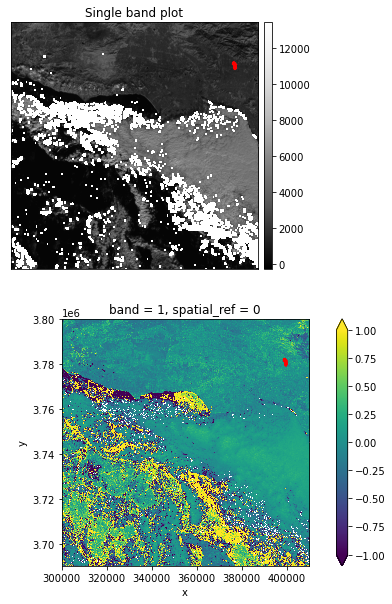

In [8]:

# #test ndmi
test_ndmi_xr = (test_rxr_8-test_rxr_11) / (test_rxr_8+test_rxr_11)


# test single band raster plot and ndmi plots  
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ep.plot_bands(test_rxr_11,
              ax=ax1,
              extent=la_plot_extent,
              cbar="greys",
             title = "Single band plot")

eaton_shape.plot(ax=ax1,
                       color='none',
                       linewidth = 3,
                       edgecolor = 'red')

test_ndmi_xr.plot.imshow(ax=ax2, 
                    vmin = -1,
                   vmax=1)
eaton_shape.plot(ax=ax2,
                color='none',
                linewidth = 3,
                edgecolor = 'red')

plt.show()

## Core Analysis 1: Loop through Sentinel-2 HLS bands, calculate NDMI for project area ##

In [9]:
# Create loop to process a sample Sentinel-2 view 

eaton_ndmi_list = []    
for tifs in ndmi_band_paths:
  
    filename = os.path.normpath(tifs).split(os.sep)[-1]
    print("Looping through",filename[-27:-20],"-",filename[-7:-4])
    site = tifs[-33:-28]
    olddate = tifs[-27:-20]
    band = tifs[-7:-4]
    
    datetimeobject = datetime.strptime(olddate,'%Y%j')
    date = datetimeobject.strftime('%m-%d-%Y')
    
    cleaned_sent = open_clean_bands(tifs,
                                    crop_bound=eaton_shape, 
                                    valid_range = (0,10000),
                                   pixel_qa_path=scene_pixel_qa_path)
    # create output 
    output = [date, band, cleaned_sent]

    #append to list before df 
    eaton_ndmi_list.append(output)
    

#Convert list of cleaned arrays with date and band to df
eaton_ndmi_df = pd.DataFrame(eaton_ndmi_list,
                       columns = ["date","band", "array"]
                      ).sort_values(by=["date"])
                                       
eaton_indexed_df = eaton_ndmi_df.set_index("date")

#Calculate NDMI through normalized difference of band 8 and 11
eaton_mean_list = []
eaton_ndmi_arrays = []
for key, value in eaton_indexed_df.groupby(["date"]):
    #define bands and perform normalized diff for ndmi
    band_8 = value['array'][0]
    band_11 = value['array'][1]
    ndmi = (band_8-band_11) / (band_8+band_11)
    
    mean_ndmi = ndmi.mean(skipna=True).item()
    
    #Create outputs for mean ndmi list (and ndmi arrays just in case) 
    output_1 = [value.index[0], mean_ndmi]
    eaton_mean_list.append(output_1)
    output_2 = [date,ndmi]
    eaton_ndmi_arrays.append(output_2)
    
    #Create dataframes for mean NDMI and NDMI arrays
    eaton_mean_df = pd.DataFrame(eaton_mean_list,
                               columns = ["date","mean"])
    eaton_mean_ndmi_df = eaton_mean_df.set_index("date")

    eaton_ndmi_df = pd.DataFrame(eaton_ndmi_arrays,
                               columns = ["date","ndmi"])
# call mean NDMI dataframe                       
eaton_mean_ndmi_df

Looping through 2021003 - B08
Looping through 2021008 - B08
Looping through 2021013 - B08
Looping through 2021018 - B08
Looping through 2021023 - B08
Looping through 2021028 - B08
Looping through 2021033 - B08
Looping through 2021038 - B08
Looping through 2021043 - B08
Looping through 2021048 - B08
Looping through 2021053 - B08
Looping through 2021058 - B08
Looping through 2021063 - B08
Looping through 2021068 - B08
Looping through 2021073 - B08
Looping through 2021078 - B08
Looping through 2021083 - B08
Looping through 2021088 - B08
Looping through 2021093 - B08
Looping through 2021098 - B08
Looping through 2021103 - B08
Looping through 2021108 - B08
Looping through 2021113 - B08
Looping through 2021118 - B08
Looping through 2021123 - B08
Looping through 2021128 - B08
Looping through 2021133 - B08
Looping through 2021138 - B08
Looping through 2021143 - B08
Looping through 2021148 - B08
Looping through 2021153 - B08
Looping through 2021163 - B08
Looping through 2021168 - B08
Looping th

,mean
date,
01-03-2021,-0.116558
01-08-2021,-0.130922
01-13-2021,0.057023
01-18-2021,-0.145306
01-23-2021,-0.629161
...,...
12-04-2021,0.075481
12-14-2021,-0.627534
12-19-2021,0.044365


## Calculate Mean NDMI for Site Area (LA Metro) For Comparison ## 

In [10]:
la_ndmi_list = []    
for tifs in ndmi_band_paths:
  
    filename = os.path.normpath(tifs).split(os.sep)[-1]
    print("Looping through",filename[-27:-20],"-",filename[-7:-4])
    site = tifs[-33:-28]
    olddate = tifs[-27:-20]
    band = tifs[-7:-4]
    
    datetimeobject = datetime.strptime(olddate,'%Y%j')
    date = datetimeobject.strftime('%m-%d-%Y')
    
    cleaned_sent = open_clean_bands(tifs,
                                    crop_bound=pasadena_shape, 
                                    valid_range = (0,10000),
                                   pixel_qa_path=scene_pixel_qa_path)
    # create output 
    output = [date, band, cleaned_sent]

    #append to list before df 
    la_ndmi_list.append(output)
    

#Convert list of cleaned arrays with date and band to df
la_ndmi_df = pd.DataFrame(la_ndmi_list,
                       columns = ["date","band", "array"]
                      ).sort_values(by=["date"])
                                       
la_indexed_df = la_ndmi_df.set_index("date")

#Calculate NDMI through normalized difference of band 8 and 11
la_mean_list = []
la_ndmi_arrays = []

for key, value in la_indexed_df.groupby(["date"]):
    #define bands and perform normalized diff for ndmi
    band_8 = value['array'][0]
    band_11 = value['array'][1]
    ndmi = (band_8-band_11) / (band_8+band_11)
    
    mean_ndmi = ndmi.mean(skipna=True).item()
    
    #Create outputs for mean ndmi list (and ndmi arrays just in case) 
    output_1 = [value.index[0], mean_ndmi]
    la_mean_list.append(output_1)
    output_2 = [date,ndmi]
    la_ndmi_arrays.append(output_2)
    
    #Create dataframes for mean NDMI and NDMI arrays
    la_mean_df = pd.DataFrame(la_mean_list,
                               columns = ["date","mean"])
    la_mean_ndmi_df = la_mean_df.set_index("date")
    
    la_ndmi_df = pd.DataFrame(la_ndmi_arrays,
                               columns = ["date","ndmi"])

# call mean NDMI dataframe                       
la_mean_ndmi_df

Looping through 2021003 - B08
Looping through 2021008 - B08
Looping through 2021013 - B08
Looping through 2021018 - B08
Looping through 2021023 - B08
Looping through 2021028 - B08
Looping through 2021033 - B08
Looping through 2021038 - B08
Looping through 2021043 - B08
Looping through 2021048 - B08
Looping through 2021053 - B08
Looping through 2021058 - B08
Looping through 2021063 - B08
Looping through 2021068 - B08
Looping through 2021073 - B08
Looping through 2021078 - B08
Looping through 2021083 - B08
Looping through 2021088 - B08
Looping through 2021093 - B08
Looping through 2021098 - B08
Looping through 2021103 - B08
Looping through 2021108 - B08
Looping through 2021113 - B08
Looping through 2021118 - B08
Looping through 2021123 - B08
Looping through 2021128 - B08
Looping through 2021133 - B08
Looping through 2021138 - B08
Looping through 2021143 - B08
Looping through 2021148 - B08
Looping through 2021153 - B08
Looping through 2021163 - B08
Looping through 2021168 - B08
Looping th

,mean
date,
01-03-2021,0.067397
01-08-2021,0.057022
01-13-2021,-0.092817
01-18-2021,0.041454
01-23-2021,-0.628745
...,...
12-04-2021,0.020285
12-14-2021,-0.561048
12-19-2021,-0.066621


## Plot NDMI with Project Area (Eaton Spreading Grounds) Boundaries ##

Text(0.5, 0.98, 'NDMI Array Comparisons')

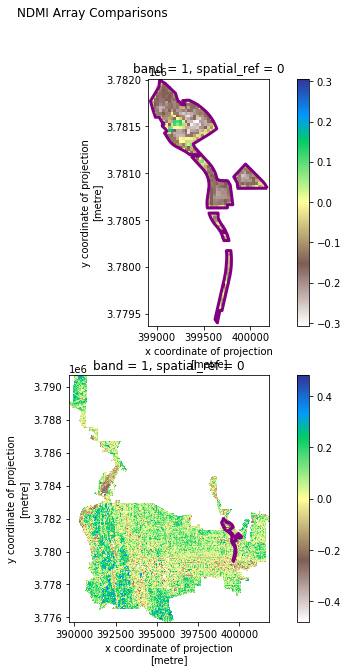

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 10))
eaton_ndmi_df["ndmi"][0].plot.imshow(ax=ax1, 
                                    cmap = "terrain_r")
eaton_shape.plot(ax=ax1,
                       color='none',
                       linewidth = 3,
                       edgecolor = 'purple')

la_ndmi_df["ndmi"][0].plot.imshow(ax=ax2,
                                 cmap = "terrain_r")
eaton_shape.plot(ax=ax2,
                       color='none',
                       linewidth = 3,
                       edgecolor = 'purple')

plt.suptitle("NDMI Array Comparisons")


Text(0.5, 1.0, '2021 Comparison of NDMI \n Eaton Spreading Grounds vs Surrounding Area (Pasadena) ')

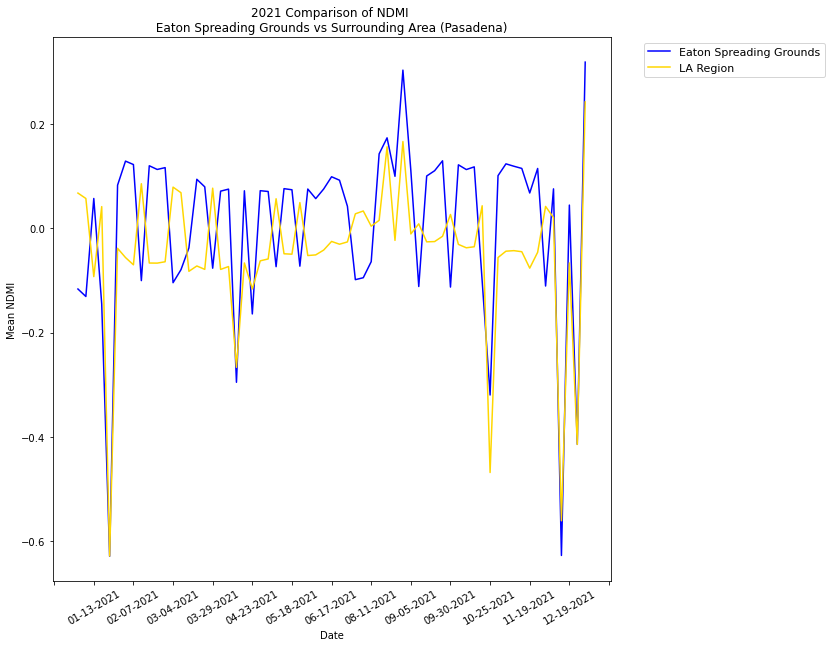

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(eaton_mean_ndmi_df.index, 
                  eaton_mean_ndmi_df["mean"],
        label="Eaton Spreading Grounds",
                  color="blue")

ax.plot(la_mean_ndmi_df.index, 
                  la_mean_ndmi_df["mean"],
        label="LA Region",
                  color="gold")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
          prop={'size': 11})

ax.set(xlabel = "Date",
       ylabel = "Mean NDMI")

plt.setp(ax.get_xticklabels(), rotation = 30)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))


plt.title("2021 Comparison of NDMI \n Eaton Spreading Grounds vs Surrounding Area (Pasadena) ")